In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

In [2]:
from btlib.engine import BacktestConfig,BacktestResults,Strategy,run_positions_only
from btlib.data.market_data import MarketData
from btlib.core.order_types import PortfolioState

def make_market() -> MarketData:
    idx = pd.date_range("2024-01-01", periods=6, freq="D")
    close = pd.DataFrame(
        {
            "AAPL": [100.0, 101.0, 102.0, 103.0, 104.0, 105.0],
            "MSFT": [200.0, 199.0, 201.0, 202.0, 203.0, 204.0],
        },
        index=idx,
    )
    return MarketData(close)
ts="2024-01-02"
data=make_market()
state=PortfolioState(ts,10000,{})
cfg=BacktestConfig()
class ClipStrategy:
    def __init__(self, sym: str):
        self.sym = sym

    def on_bar(self, ts, data_upto_ts, state):
        return {self.sym: 2.0}  # intentionally too large
cs=ClipStrategy("AAPL")

rs=run_positions_only(data,cs,cfg)
print(rs.ledger)



                    cash        equity  gross_exposure  net_exposure  \
ts                                                                     
2024-01-01  100000.00000  100000.00000         0.00000       0.00000   
2024-01-02   -1000.00000  100000.00000    101000.00000  101000.00000   
2024-01-03       9.90099  101000.00000    100990.09901  100990.09901   
2024-01-04       9.90099  101990.09901    101980.19802  101980.19802   
2024-01-05       9.90099  102980.19802    102970.29703  102970.29703   
2024-01-06       9.90099  103970.29703    103960.39604  103960.39604   

            leverage  n_positions  
ts                                 
2024-01-01  0.000000            2  
2024-01-02  1.010000            2  
2024-01-03  0.999902            2  
2024-01-04  0.999903            2  
2024-01-05  0.999904            2  
2024-01-06  0.999905            2  


=== PRICES (close) ===


,AAPL
2024-01-01,100.0
2024-01-02,110.0
2024-01-03,90.0
2024-01-04,120.0


=== TARGETS (weights) ===


,AAPL
ts,
2024-01-01,1.0
2024-01-02,0.0
2024-01-03,0.0
2024-01-04,0.0


=== ORDERS (submitted at t) ===


,symbol,qty,order_type,tag
ts,,,,
2024-01-01,AAPL,10.0,OrderType.MARKET,None
2024-01-02,AAPL,-10.0,OrderType.MARKET,None


=== FILLS (filled at t+1) ===


,symbol,qty,price,fees,slippage,order_tag
ts,,,,,,
2024-01-02,AAPL,10.0,110.0,0.0,0.0,None
2024-01-03,AAPL,-10.0,90.0,0.0,0.0,None


=== LEDGER ===


,cash,equity,gross_exposure,net_exposure,leverage,n_positions
ts,,,,,,
2024-01-01,1000.0,1000.0,0.0,0.0,0.0,1
2024-01-02,-100.0,1000.0,1100.0,1100.0,1.1,1
2024-01-03,800.0,800.0,0.0,0.0,0.0,1
2024-01-04,800.0,800.0,0.0,0.0,0.0,1


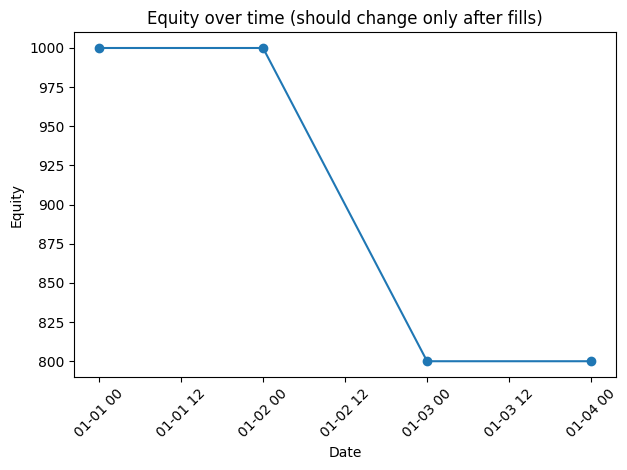

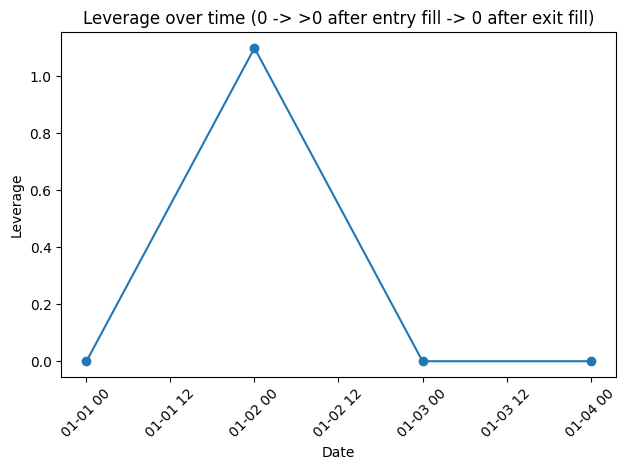


Sanity:
First order submit ts: 2024-01-01 00:00:00
First fill ts: 2024-01-02 00:00:00
First fill price: 110.0
Price at submit bar: 100.0
Price at fill bar: 110.0


In [3]:
# JUPYTER CELL: minimal visual smoke-test for Day 7 engine timing (orders at t, fills at t+1)

import pandas as pd
import numpy as np

from btlib.data.market_data import MarketData
from btlib.engine.config import BacktestConfig
from btlib.execution.next_close import NextCloseExecution

# import your engine runner (adjust path if needed)
from btlib.engine.engine import run_positions_only


# --- 1) Tiny market: 4 days, one symbol ---
idx = pd.date_range("2024-01-01", periods=4, freq="D")
close = pd.DataFrame({"AAPL": [100.0, 110.0, 90.0, 120.0]}, index=idx)
market = MarketData(close)


# --- 2) Simple strategy: Day0 long 1.0, Day1 flat 0.0, rest flat ---
class LongThenFlat:
    def __init__(self, sym: str, t0: pd.Timestamp, t1: pd.Timestamp):
        self.sym = sym
        self.t0 = t0
        self.t1 = t1

    def on_bar(self, ts, data_upto_ts, state):
        if ts == self.t0:
            return {self.sym: 1.0}
        if ts == self.t1:
            return {self.sym: 0.0}
        return {self.sym: 0.0}


cfg = BacktestConfig(
    initial_cash=1000.0,
    warmup_bars=0,
    max_abs_weight=1.0,
    allow_fractional_shares=True,
    min_order_notional=0.0,   # makes the demo deterministic (no order filtered out as "dust")
)

strategy = LongThenFlat("AAPL", t0=idx[0], t1=idx[1])
exec_model = NextCloseExecution()


# --- 3) Run backtest ---
res = run_positions_only(market, strategy, cfg, exec_model)


# --- 4) Pretty tables to confirm timing ---
print("=== PRICES (close) ===")
display(close)

print("=== TARGETS (weights) ===")
display(res.targets)

print("=== ORDERS (submitted at t) ===")
display(res.orders)

print("=== FILLS (filled at t+1) ===")
display(res.fills)

print("=== LEDGER ===")
display(res.ledger)


# --- 5) Quick visual: equity + leverage over time ---
import matplotlib.pyplot as plt

# Equity plot
plt.figure()
plt.plot(res.ledger.index, res.ledger["equity"], marker="o")
plt.title("Equity over time (should change only after fills)")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Leverage plot
plt.figure()
plt.plot(res.ledger.index, res.ledger["leverage"], marker="o")
plt.title("Leverage over time (0 -> >0 after entry fill -> 0 after exit fill)")
plt.xlabel("Date")
plt.ylabel("Leverage")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# --- 6) Sanity checks (timing assertions) ---
# Order at Day0 fills Day1, order at Day1 fills Day2 (even though Day2 target is flat already)
if not res.fills.empty:
    print("\nSanity:")
    print("First order submit ts:", res.orders.index.min() if not res.orders.empty else None)
    print("First fill ts:", res.fills.index.min())
    print("First fill price:", float(res.fills.iloc[0]["price"]))
    print("Price at submit bar:", float(close.loc[res.orders.index.min(), "AAPL"]) if not res.orders.empty else None)
    print("Price at fill bar:", float(close.loc[res.fills.index.min(), "AAPL"]))
